Berekening van de Solid Angle

$$\Omega=\iint_S \frac{dA}{r^2}$$
$$w(\theta) = x_0 \,\cos\theta ,\\[2pt]$$
$$l         = y_0 ,\\[2pt]$$
$$h(\theta) = h_0 \,\sec\theta.$$

$$
\boxed{%
\Omega(\theta) \;=\;
4\;\arctan\!\biggl(
  \frac{\,w(\theta)\,l\,}
       {\,\dfrac{h(\theta)}{2}\;
        \sqrt{\,w(\theta)^2 + l^2 + \bigl(\tfrac{h(\theta)}{2}\bigr)^2}}
\biggr)
}
$$

Berekening van de Effectieve Oppervlakte

$$
\boxed{%
A \;=\; 2(\;x_0 + \;y_0)\,l
            \;=\; x_0\,y_0\;\cos\theta
}
$$

 Hoek° Zijde  Runs  Gem.flux        σ
     0     E     2  3.240763 0.045685
     0     W     2  3.240763 0.045685
    20     E     2  2.553938 0.051905
    20     W     2  3.168997 0.019203
    40     E     2  2.093274 0.019811
    40     W     2  2.367394 0.048045
    60     E     2  2.034122 0.018810
    60     W     2  2.167402 0.036938

Fit:  A = 2.987 ± 0.01868,  n = 0.6353 ± 0.01701
χ²/dof = 834.47 / 4  →  208.62



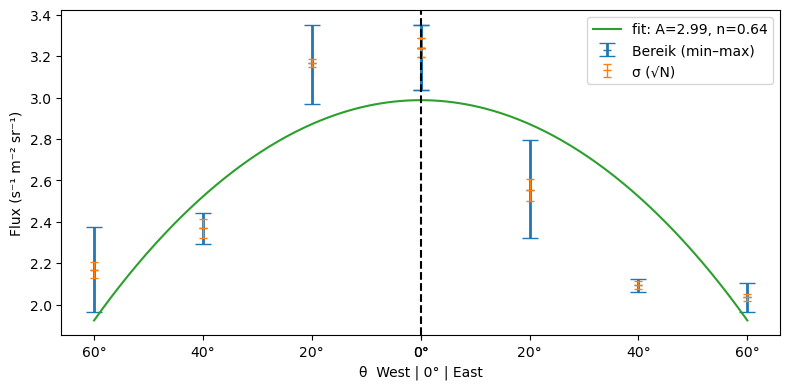

In [ ]:
import math
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpmath import sec

# ------------------------------------------------------------
# Basisafmetingen in meter (zoals in het oorspronkelijke script)
# ------------------------------------------------------------
# x₀ = halve breedte, y₀ = halve lengte, h₀ = afstand tussen middens
x_0 = 4.5e-2
y_0 = 20.0e-2
h_0 = 86.0e-2
z_0 = 2.5e-2

def get_x_projection(theta_deg):
    """Halve breedte‐projectie bij helling θ (deg)."""
    return x_0 * math.cos(math.radians(theta_deg))


def get_h_projection(theta_deg):
    """Projectie van de middenafstand h₀ op de verticaal."""
    return h_0 /math.cos(math.radians(theta_deg))


def get_solid_angle(theta_deg):
    x_proj = get_x_projection(theta_deg)
    h_proj = get_h_projection(theta_deg)
    return 4 * math.atan(
        (x_proj * y_0)
        / ((h_proj / 2) * math.sqrt(x_proj ** 2 + y_0 ** 2 + (h_proj / 2) ** 2))
    )


def get_area(theta_deg):
    """Effectief oppervlak bij hoek θ (deg)."""
    return 2 * (x_0 + z_0) * 2 * y_0

files = [
    "hoek_0_c1.csv", "hoek_0_c2.csv",
    "hoek_20_E_c1.csv", "hoek_20_E_c2.csv", "hoek_20_W_c1.csv", "hoek_20_W_c2.csv",
    "hoek_40_E_c1.csv", "hoek_40_E_c2.csv", "hoek_40_W_c1.csv", "hoek_40_W_c2.csv",
    "hoek_60_E_c1.csv", "hoek_60_E_c2.csv", "hoek_60_W_c1.csv", "hoek_60_W_c2.csv",
]

stats = {}
for name in files:
    if not pathlib.Path(name).exists():
        continue

    parts = name.split("_")
    angle = int(parts[1])        # 0, 20, 40, 60 … (graden)
    side  = "E" if "E" in parts else "W" if "W" in parts else "E"

    header = pd.read_csv(name, nrows=1)
    N = int(header["Total coincidences"][0])
    t = float(header["Total runtime (s)"][0])

    area        = get_area(angle)
    solid_angle = get_solid_angle(angle)
    flux_run    = N / (t * area * solid_angle)

    key = (angle, side)
    d = stats.setdefault(key, {"N": 0, "t": 0.0, "runs": []})
    d["N"]    += N
    d["t"]    += t
    d["runs"].append(flux_run)

# Symmetriepunt 0° spiegelen indien nodig
if (0, "E") in stats and (0, "W") not in stats:
    stats[(0, "W")] = stats[(0, "E")]

# ------------------------------------------------------------
# Samenvatten & foutbalken
# ------------------------------------------------------------
rows, x, y, lo, hi, sigma = [], [], [], [], [], []
for (angle, side), d in sorted(stats.items()):
    area        = get_area(angle)
    solid_angle = get_solid_angle(angle)
    mean  = d["N"] / (d["t"] * area * solid_angle)
    err   = math.sqrt(d["N"]) / (d["t"] * area * solid_angle)

    rows.append([angle, side, len(d["runs"]), mean, err])

    pos = angle if side == "E" else -angle
    x.append(pos)
    y.append(mean)
    lo.append(max(0, mean - min(d["runs"])))  # nooit negatief
    hi.append(max(0, max(d["runs"]) - mean))
    sigma.append(err)

# DataFrame voor console‑weergave
result = pd.DataFrame(rows, columns=["Hoek°", "Zijde", "Runs", "Gem.flux", "σ"])
print(result.to_string(index=False))

# ------------------------------------------------------------
# Fit: I(θ) = A · cosⁿ θ  (θ in graden, |θ| voor symmetrie)
# ------------------------------------------------------------

def cosn(theta_deg, A, n):
    return A * np.cos(np.deg2rad(np.abs(theta_deg))) ** n

x_arr     = np.array(x)
y_arr     = np.array(y)
sigma_arr = np.array(sigma)
mask = np.abs(x_arr) > 0            # negeer 0° bij fit (slappe informatie)

popt, pcov = curve_fit(
    cosn, x_arr[mask], y_arr[mask], p0=(y_arr.max(), 2.0), sigma=sigma_arr[mask],
    absolute_sigma=True
)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum(((y_arr[mask] - cosn(x_arr[mask], *popt)) / sigma_arr[mask]) ** 2)
dof  = mask.sum() - len(popt)

print(
    f"\nFit:  A = {popt[0]:.4g} ± {perr[0]:.4g},  n = {popt[1]:.4g} ± {perr[1]:.4g}"
)
print(f"χ²/dof = {chi2:.2f} / {dof:d}  →  {chi2/dof:.2f}\n")

# ------------------------------------------------------------
# Plot (met niet‑negatieve y‑foutbalken + fitcurve)
# ------------------------------------------------------------
lo    = np.clip(lo,    0, None)
hi    = np.clip(hi,    0, None)
sigma = np.clip(sigma, 0, None)

plt.figure(figsize=(8, 4))
plt.errorbar(x, y, yerr=[lo, hi], fmt="_", elinewidth=2, capsize=6,
             label="Bereik (min–max)")
plt.errorbar(x, y, yerr=sigma, fmt="_", elinewidth=1, capsize=3,
             label="σ (√N)")

# Fit‑curve over ±60°
grid = np.linspace(-60, 60, 301)
plt.plot(grid, cosn(grid, *popt), label=f"fit: A={popt[0]:.3g}, n={popt[1]:.2f}")

plt.axvline(0, color="k", ls="--")
plt.xticks(x, [f"{abs(v):.0f}°" for v in x])
plt.xlabel("θ  West | 0° | East")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


Data‐analyse (Veel wiskunde hier wordt direct door NumPy uirgevoerd, en niet expliciet uitgeschreven)

1. Flux per run
$$
I_i(\theta)
  = \frac{N_i}{\,t_i\,A(\theta)\,\Omega(\theta)\,},
$$
waar $N_i$ het aantal coincidences is en $t_i$ de looptijd.

2. Samengestelde (gecombineerde) flux per hoek
$$
\bar I(\theta)
  = \frac{\sum_i N_i}{\sum_i t_i\,A(\theta)\,\Omega(\theta)}.
$$

3. Statistische onzekerheid (σ) op de gecombineerde flux
   – veronderstelt Poisson‐statistiek ($σ_N = \sqrt{N}$)
$$
\sigma_{\bar I}(\theta)
  = \frac{\sqrt{\sum_i N_i}}{\sum_i t_i\,A(\theta)\,\Omega(\theta)}.
$$

4. Gewogen $cos^n$-fit.

$$\text{Model : }I_{\text{mod}}(\theta) = A\cos^{n}\theta$$

$$\text{Parameters : }A, n$$

5. Gewogen (1/σ²) χ²:
$$
\chi^{2}(A,n)
  = \sum_{k=1}^{N_{\text{dat}}}
    \frac{\bigl[\;I_k^{\text{obs}} - A\cos^{n}\theta_k\bigr]^{2}}
         {\sigma_k^{2}}.
$$

6. Optimale parameters

$$(A, n) = \arg\min \chi^{2}(A,n)$$
Covariantiematrix uit de fit:
$$\mathbf C = \left(\frac{\partial^{2}\chi^{2}}{\partial p_i \partial p_j}\right)^{-1}$$
-> 1-σ fouten:
$$
\sigma_{A} = \sqrt{C_{AA}}, \qquad
\sigma_{n} = \sqrt{C_{nn}}.
$$

7. Goodness of Fit

$$
\nu = N_{\text{dat}} - N_{\text{par}}, \qquad
\chi^{2}_{\nu} = \frac{\chi^{2}}{\nu}.
$$
Een waarde $\chi^{2}_{\nu}\!\approx 1$ wijst op een consistente
error‐inschatting.


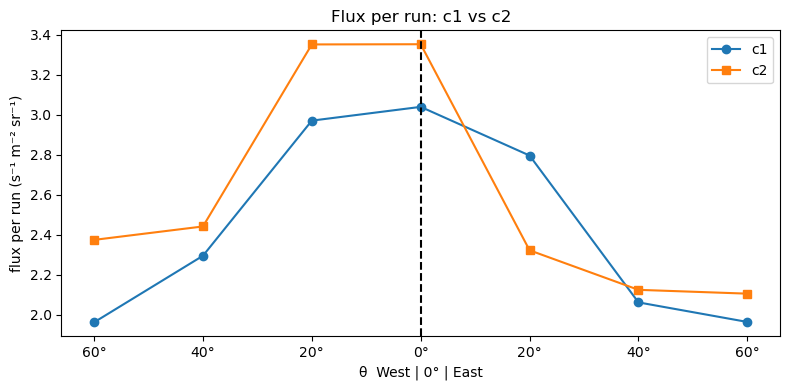

In [136]:
c1_x, c1_y, c2_x, c2_y = [], [], [], []

for fname in files:
    if not pathlib.Path(fname).exists():
        continue
    parts = fname.split("_")
    angle = int(parts[1])
    side  = "E" if "E" in parts else "W" if "W" in parts else "E"
    pos   = angle if side == "E" else -angle

    header = pd.read_csv(fname, nrows=1)
    N = int(header["Total coincidences"][0])
    t = float(header["Total runtime (s)"][0])
    area  = get_area(angle)
    solid = get_solid_angle(angle)
    flux  = N / (t * area * solid)

    if "c1" in fname:
        c1_x.append(pos); c1_y.append(flux)
    elif "c2" in fname:
        c2_x.append(pos); c2_y.append(flux)

c1_order = np.argsort(c1_x)
c2_order = np.argsort(c2_x)

plt.figure(figsize=(8, 4))
plt.plot(np.array(c1_x)[c1_order], np.array(c1_y)[c1_order], "o-", label="c1")
plt.plot(np.array(c2_x)[c2_order], np.array(c2_y)[c2_order], "s-", label="c2")
plt.axvline(0, color="k", ls="--")
ticks = sorted(set(c1_x + c2_x))
plt.xticks(ticks, [f"{abs(v):.0f}°" for v in ticks])
plt.xlabel("θ  West | 0° | East")
plt.ylabel("flux per run (s⁻¹ m⁻² sr⁻¹)")
plt.title("Flux per run: c1 vs c2")
plt.legend()
plt.tight_layout()
plt.show()